In [12]:
#basics
import numpy as np
import pandas as pd 
import polars as pl
import seaborn as sns
import time
import matplotlib.pyplot as plt
import missingno as msno

import warnings
warnings.filterwarnings("ignore")

#preprocessing
from sklearn.preprocessing import StandardScaler, PowerTransformer, MinMaxScaler, LabelEncoder,OneHotEncoder, OrdinalEncoder

#feature engineering
from sklearn.feature_selection import mutual_info_classif


#transformers and pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.base import clone
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline, make_pipeline, FeatureUnion
from sklearn import set_config

#algorithms
from xgboost import XGBClassifier
import xgboost as xgb
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
from sklearn.base import clone
from lightgbm import early_stopping
from lightgbm import log_evaluation
from sklearn.linear_model import LogisticRegression


#model evaluation
from sklearn.model_selection import cross_val_score, cross_validate
from sklearn.model_selection import StratifiedShuffleSplit, StratifiedKFold
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, log_loss, auc, accuracy_score, balanced_accuracy_score
from sklearn.metrics import make_scorer, RocCurveDisplay, confusion_matrix

# Optuna and visualization tools
import optuna
from optuna.samplers import TPESampler
from optuna.visualization import plot_contour
from optuna.visualization import plot_edf
from optuna.visualization import plot_intermediate_values
from optuna.visualization import plot_optimization_history
from optuna.visualization import plot_parallel_coordinate
from optuna.visualization import plot_param_importances
from optuna.visualization import plot_slice

random_state = 42

In [13]:
# Read the data
train_df = pd.read_csv(r'D:\workspace\py_pj\ins_pj\data\train.csv', index_col='id')
test_df = pd.read_csv(r'D:\workspace\py_pj\ins_pj\data\test.csv', index_col='id')
original_df = pd.read_csv(r"D:\workspace\py_pj\ins_pj\data\sample_submission.csv", index_col=[0])

train_df.head()

,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response
id,,,,,,,,,,,
1,Male,44,1,28.0,0,> 2 Years,Yes,40454.0,26.0,217,1
2,Male,76,1,3.0,0,1-2 Year,No,33536.0,26.0,183,0
3,Male,47,1,28.0,0,> 2 Years,Yes,38294.0,26.0,27,1
4,Male,21,1,11.0,1,< 1 Year,No,28619.0,152.0,203,0
5,Female,29,1,41.0,1,< 1 Year,No,27496.0,152.0,39,0


In [14]:
print(train_df.shape)
print(test_df.shape)
print(original_df.shape)

(381109, 11)
(127037, 10)
(127037, 1)


In [15]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 381109 entries, 1 to 381109
Data columns (total 11 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   Gender                381109 non-null  object 
 1   Age                   381109 non-null  int64  
 2   Driving_License       381109 non-null  int64  
 3   Region_Code           381109 non-null  float64
 4   Previously_Insured    381109 non-null  int64  
 5   Vehicle_Age           381109 non-null  object 
 6   Vehicle_Damage        381109 non-null  object 
 7   Annual_Premium        381109 non-null  float64
 8   Policy_Sales_Channel  381109 non-null  float64
 9   Vintage               381109 non-null  int64  
 10  Response              381109 non-null  int64  
dtypes: float64(3), int64(5), object(3)
memory usage: 34.9+ MB


In [16]:
#This function reduces memory usage. Reference: https://www.kaggle.com/code/jmascacibar/optimizing-memory-usage-with-insurance-cross-sell/notebook
def shrink_and_dummify(df):
    df["Vehicle_Age"] = df["Vehicle_Age"].replace({"1-2 Year": 1, "< 1 Year": 0, "> 2 Years": 2}).astype('int8')
    df['Gender'] = df['Gender'].replace({'Male': 0, 'Female': 1}).astype('int8')
    df['Vehicle_Damage'] = df['Vehicle_Damage'].replace({'No': 0, 'Yes': 1}).astype('int8')
    df['Age'] = df['Age'].astype('int8')
    df['Driving_License'] = df['Driving_License'].astype('int8')
    df['Region_Code'] = df['Region_Code'].astype('int8')
    df['Previously_Insured'] = df['Previously_Insured'].astype('int8')
    df['Annual_Premium'] = df['Annual_Premium'].astype('int32')
    df['Policy_Sales_Channel'] = df['Policy_Sales_Channel'].astype('int16')
    df['Vintage'] = df['Vintage'].astype('int16')
    
    if 'Response' in df.columns:
        df['Response'] = df['Response'].astype('int8')
    
    return df

In [17]:
train_df = shrink_and_dummify(train_df)
test_df = shrink_and_dummify(test_df)
original_df = shrink_and_dummify(original_df)

KeyError: 'Vehicle_Age'

In [19]:
#numerical feature descriptive statistics

train_df.describe().T

,count,mean,std,min,25%,50%,75%,max
Gender,381109.0,0.459239,0.498336,0.0,0.0,0.0,1.0,1.0
Age,381109.0,38.822584,15.511611,20.0,25.0,36.0,49.0,85.0
Driving_License,381109.0,0.997869,0.046110,0.0,1.0,1.0,1.0,1.0
Region_Code,381109.0,26.388807,13.229888,0.0,15.0,28.0,35.0,52.0
Previously_Insured,381109.0,0.458210,0.498251,0.0,0.0,0.0,1.0,1.0
Vehicle_Age,381109.0,0.609616,0.567439,0.0,0.0,1.0,1.0,2.0
Vehicle_Damage,381109.0,0.504877,0.499977,0.0,0.0,1.0,1.0,1.0
Annual_Premium,381109.0,30564.389581,17213.155057,2630.0,24405.0,31669.0,39400.0,540165.0
Policy_Sales_Channel,381109.0,112.034295,54.203995,1.0,29.0,133.0,152.0,163.0
Vintage,381109.0,154.347397,83.671304,10.0,82.0,154.0,227.0,299.0


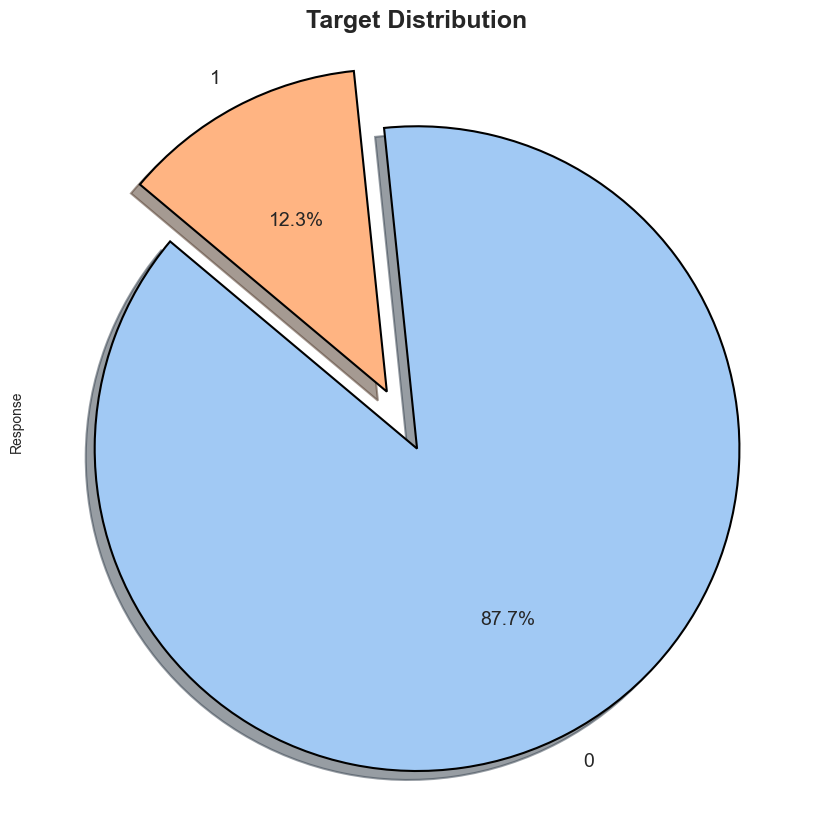

In [20]:
#Target frequency

plt.figure(figsize=(10, 10))
palette_color = sns.color_palette('pastel')
explode = [0.1 for _ in range(train_df['Response'].nunique())]

# Plotting
train_df.groupby('Response')['Response'].count().plot.pie(
    colors=palette_color,
    explode=explode,
    autopct="%1.1f%%",
    shadow=True,  # Adding shadow for better visibility
    startangle=140,  # Start angle for better alignment
    textprops={'fontsize': 14},  # Adjust text size
    wedgeprops={'edgecolor': 'black', 'linewidth': 1.5}  # Adding edge color and width
)

# Adding a title
plt.title('Target Distribution', fontsize=18, weight='bold')

# Equal aspect ratio ensures that pie is drawn as a circle.
plt.axis('equal')

# Displaying the plot
plt.show()

In [21]:
train_df.nunique().sort_values()

Gender                      2
Driving_License             2
Previously_Insured          2
Vehicle_Damage              2
Response                    2
Vehicle_Age                 3
Region_Code                53
Age                        66
Policy_Sales_Channel      155
Vintage                   290
Annual_Premium          48838
dtype: int64

In [22]:
# Store numerical and categorical features to different lists for visualization purposes
feature_list = [feature for feature in train_df.columns if not feature  == "Response"]

target = "Response"

descrete_features = ['Previously_Insured','Driving_License', 'Gender', 'Vehicle_Damage', 'Vehicle_Age']


continuous_features = list(set(feature_list) - set(descrete_features))

assert feature_list.sort() == (continuous_features + descrete_features).sort()

In [23]:
eda_df = train_df.sample(frac= 0.01)

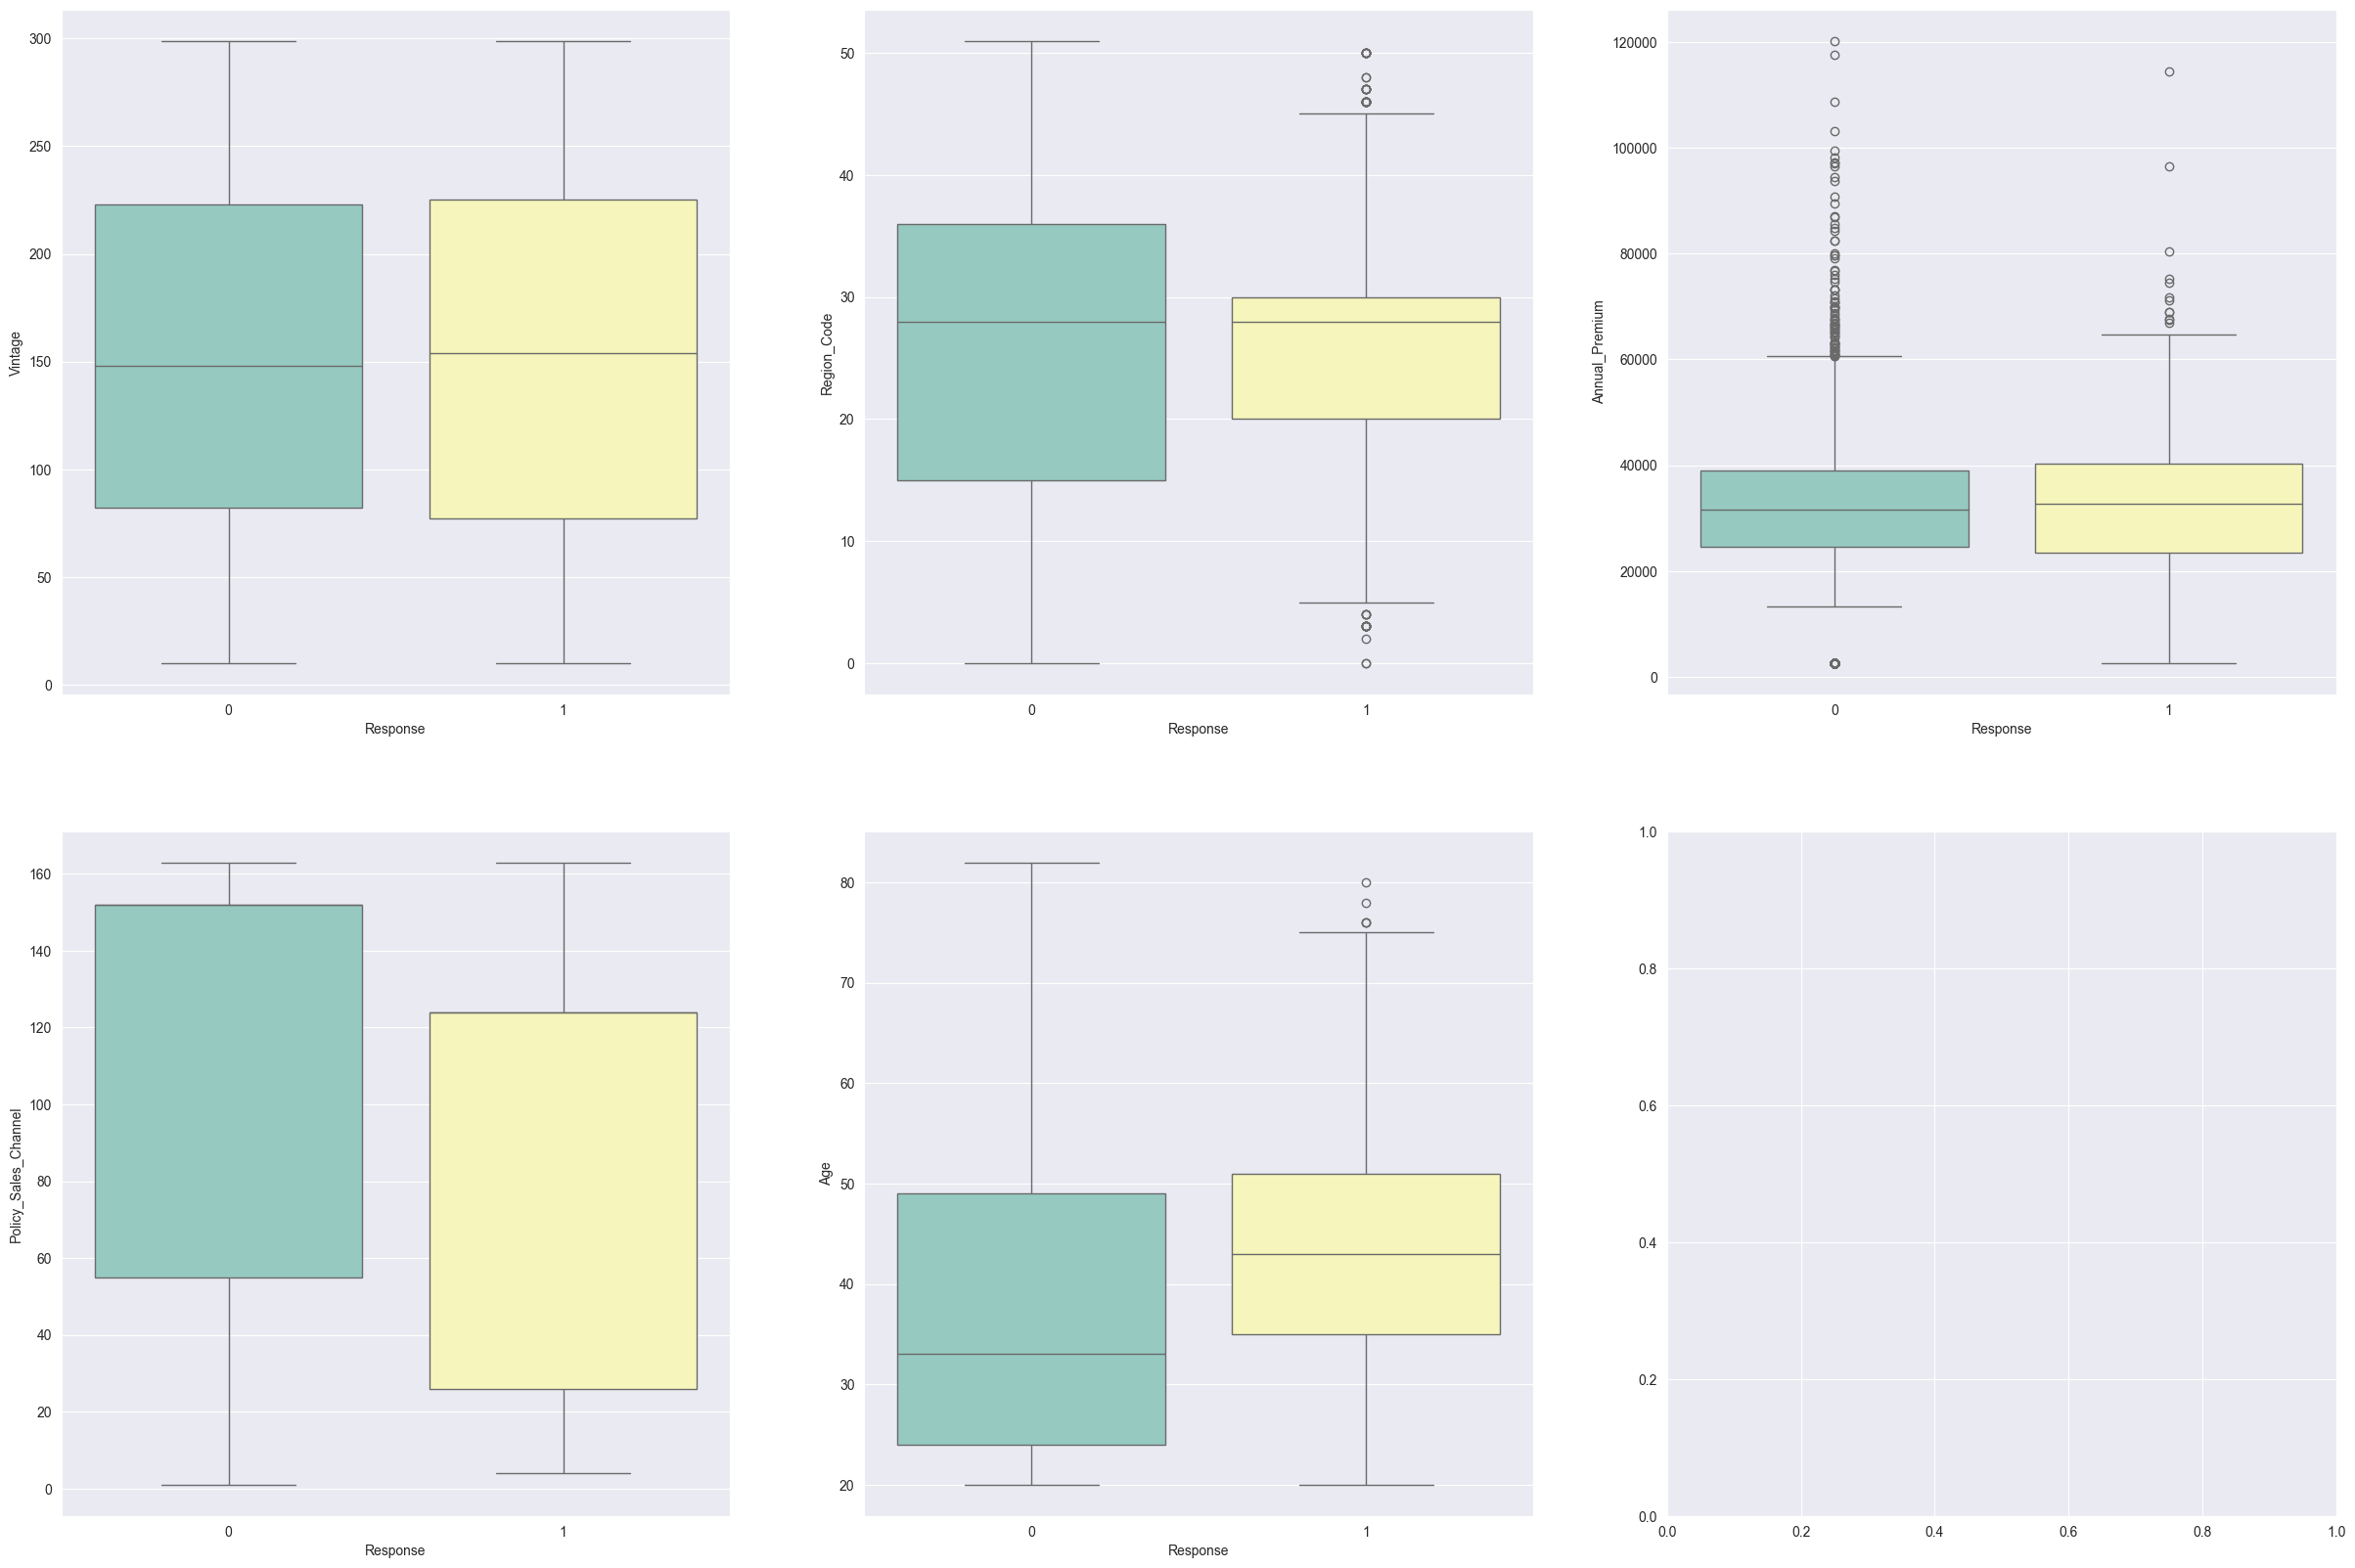

In [24]:
fig, ax = plt.subplots(2, 3, figsize=(30, 20))
for var, subplot in zip(continuous_features, ax.flatten()):
    sns.boxplot(x='Response', y=var, data=eda_df, ax=subplot, palette='Set3')

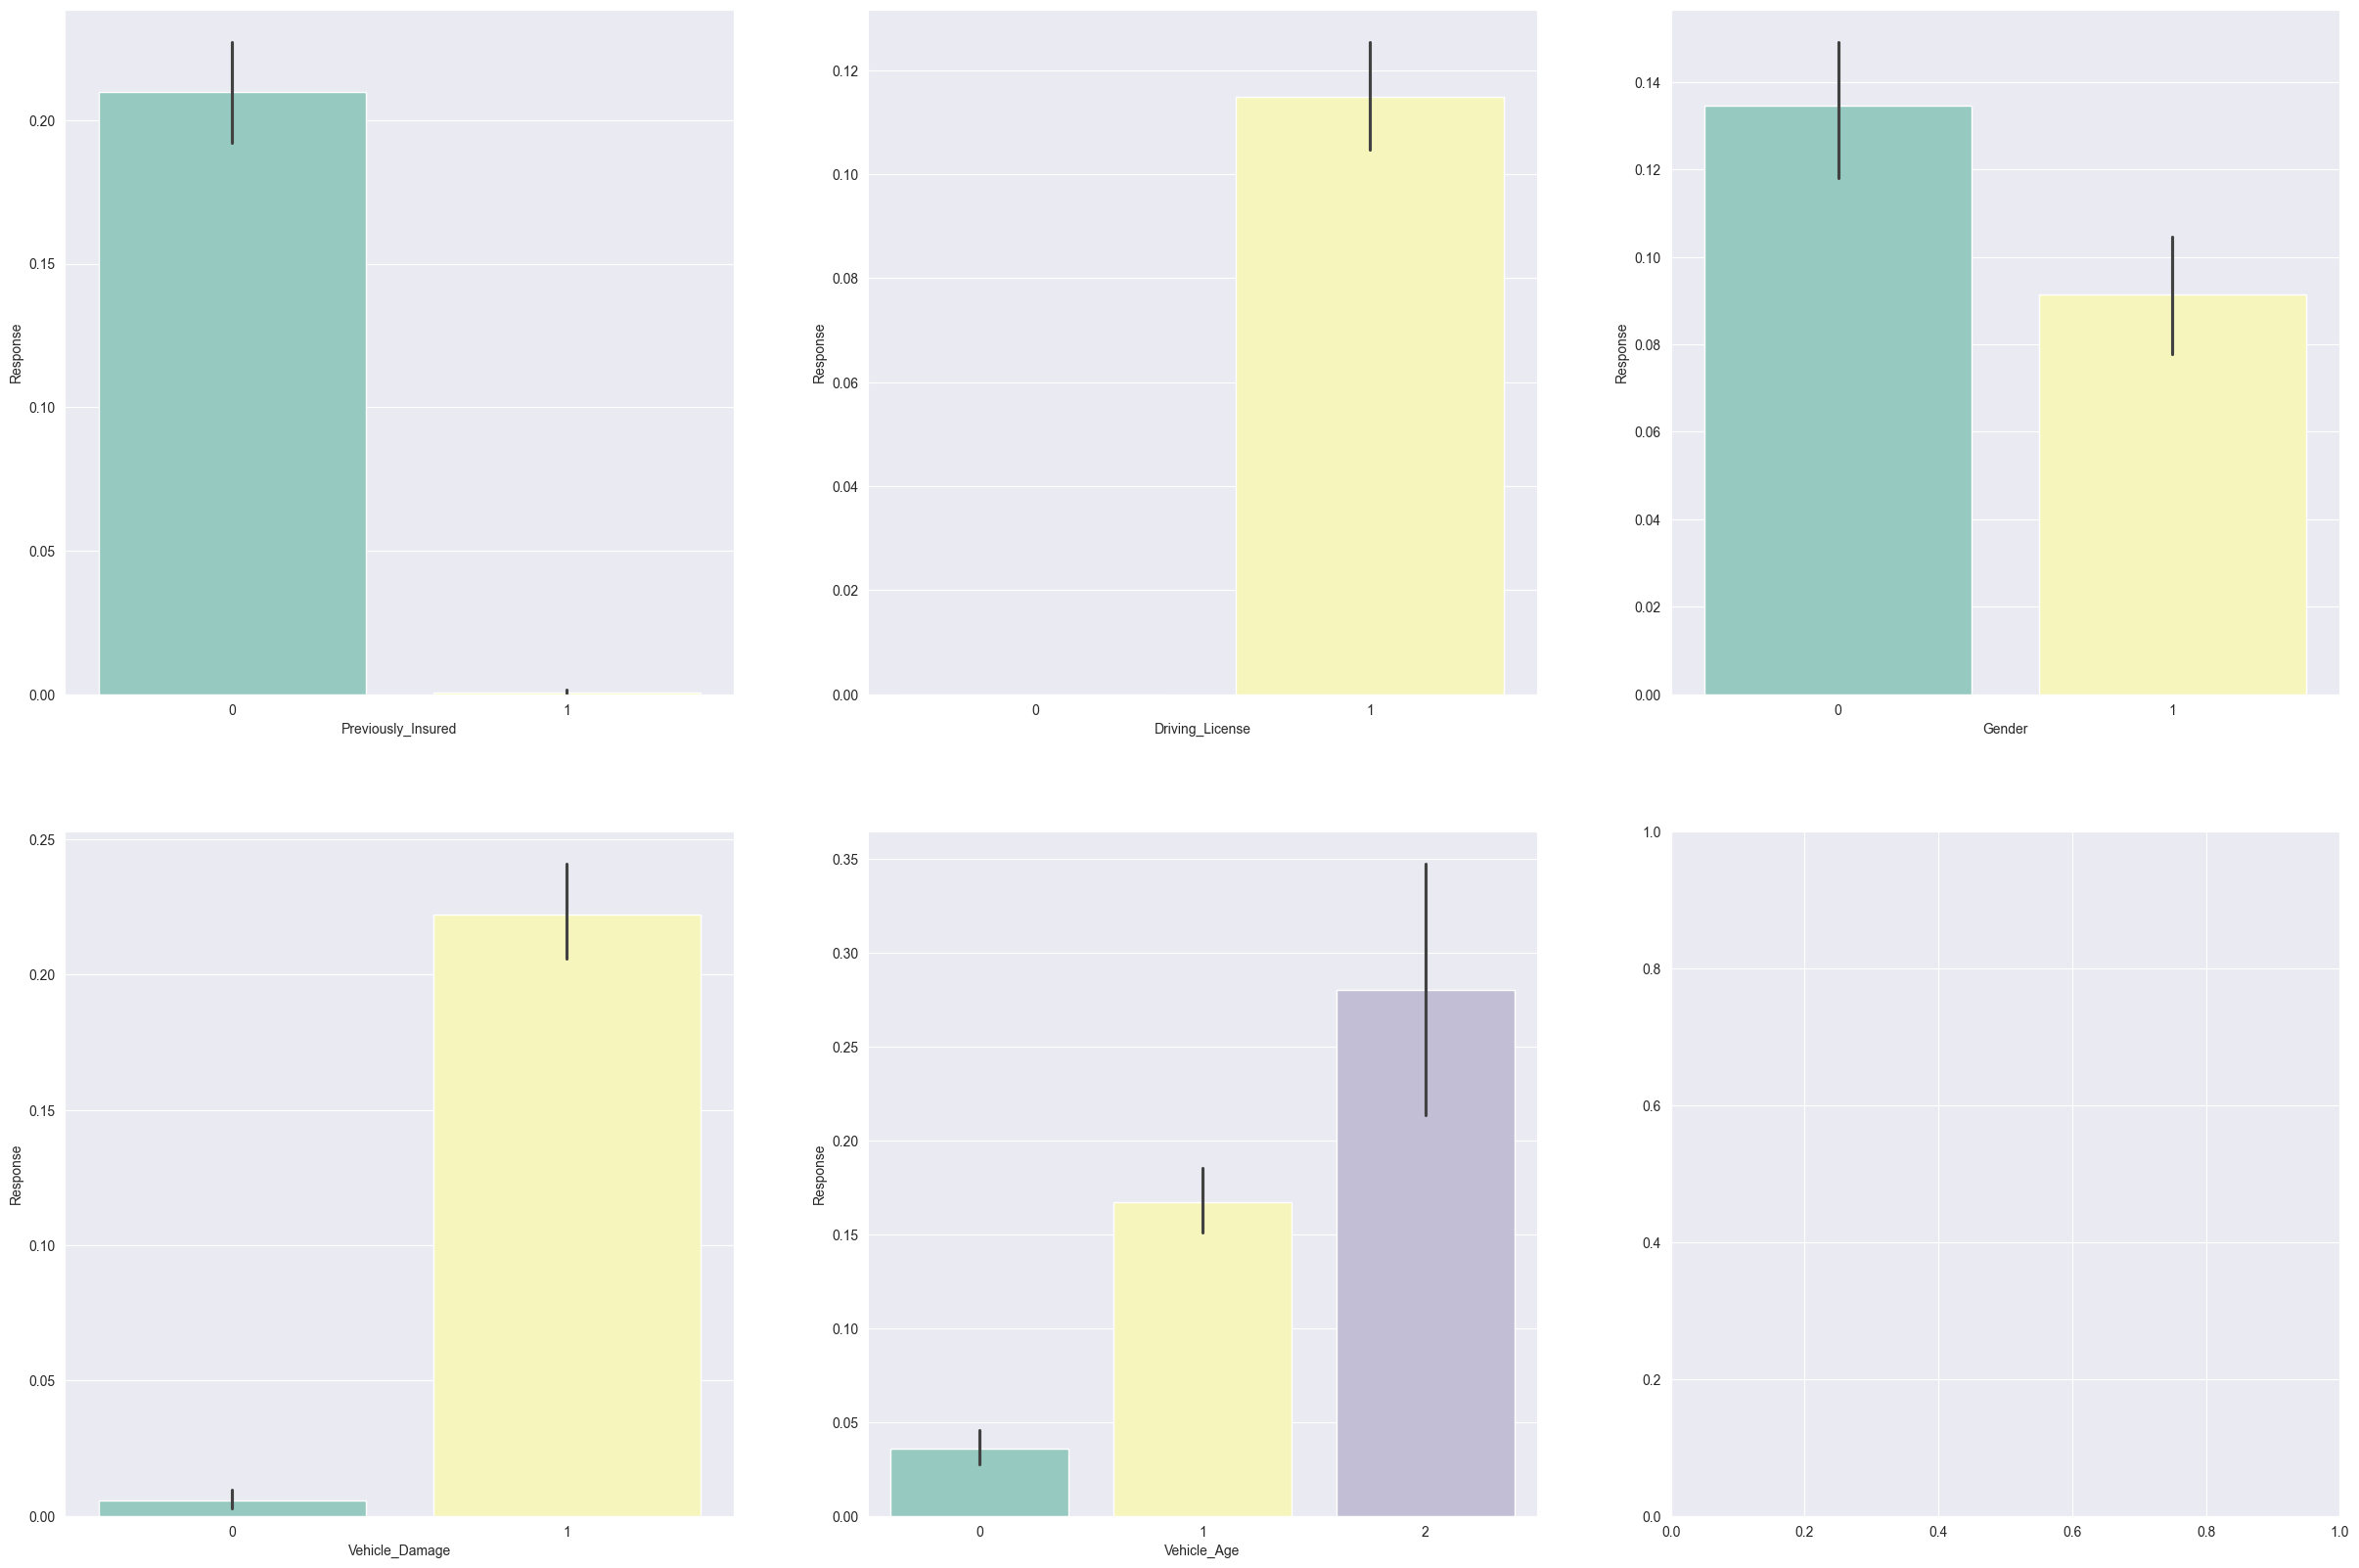

In [25]:
fig, ax = plt.subplots(2, 3, figsize=(30, 20))
for var, subplot in zip(descrete_features, ax.flatten()):
    sns.barplot(x= var, y= 'Response', data=eda_df, ax=subplot, palette='Set3')

In [26]:
# determine the mutual information for features

mutual_df = eda_df[feature_list]
y_sampled = eda_df.Response
mutual_info = mutual_info_classif(mutual_df, y_sampled, random_state=random_state)

mutual_info = pd.Series(mutual_info)
mutual_info.index = mutual_df.columns
mutual_info = pd.DataFrame(mutual_info.sort_values(ascending=False), columns = ["Numerical_Feature_MI"] )
mutual_info.style.background_gradient("cool")

,Numerical_Feature_MI
Vehicle_Damage,0.085674
Previously_Insured,0.078616
Policy_Sales_Channel,0.034660
Vehicle_Age,0.030286
Age,0.024674
Region_Code,0.015539
Driving_License,0.004264
Annual_Premium,0.003724
Gender,0.000000
Vintage,0.000000


In [27]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

In [28]:
#A cross-validation function with early stopping. I used some crowdy code  to get the best iterations. If you have more elegant suggestions, please put the comment.

def cross_validate_score(model, data: pd.DataFrame, cv=None, test_data: pd.DataFrame = None, label: str = 'Response', include_original: bool = True, original_data: pd.DataFrame = None):
    if cv is None:
        cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    if test_data is None:
        raise ValueError("test_data must be provided")
    
    X = data.copy()
    y = X.pop(label)
    
    val_predictions = np.zeros(len(X))
    test_predictions = np.zeros(len(test_data))
    train_scores, val_scores = [], []
    
    for fold, (train_idx, val_idx) in enumerate(cv.split(X, y)):
        X_train = X.iloc[train_idx].reset_index(drop=True)
        y_train = y.iloc[train_idx].reset_index(drop=True)
        X_val = X.iloc[val_idx].reset_index(drop=True)
        y_val = y.iloc[val_idx].reset_index(drop=True)
        
        if include_original:
            if original_data is None:
                raise ValueError("original_data must be provided when include_original is True")
            X_train = pd.concat([original_data.drop(label, axis=1), X_train]).reset_index(drop=True)
            y_train = pd.concat([original_data[label], y_train]).reset_index(drop=True)
        
        model_cloned = clone(model)
        
        if isinstance(model_cloned, XGBClassifier):
            eval_set = [(X_val, y_val)]
            model_cloned.fit(X_train, y_train, eval_set=eval_set, early_stopping_rounds=50, verbose=False)
            best_iteration = model_cloned.best_iteration
            train_preds_proba = model_cloned.predict_proba(X_train, iteration_range=(0, best_iteration))[:, 1]
            val_preds_proba = model_cloned.predict_proba(X_val, iteration_range=(0, best_iteration))[:, 1]
            test_preds_proba = model_cloned.predict_proba(test_data, iteration_range=(0, best_iteration))[:, 1]
        elif isinstance(model_cloned, LGBMClassifier):
            eval_set = [(X_val, y_val)]
            model_cloned.fit(X_train, y_train, eval_set=eval_set, eval_metric='auc', callbacks=[early_stopping(50)])
            best_iteration = model_cloned.best_iteration_
            train_preds_proba = model_cloned.predict_proba(X_train, num_iteration=best_iteration)[:, 1]
            val_preds_proba = model_cloned.predict_proba(X_val, num_iteration=best_iteration)[:, 1]
            test_preds_proba = model_cloned.predict_proba(test_data, num_iteration=best_iteration)[:, 1]
        elif isinstance(model_cloned, CatBoostClassifier):
            model_cloned.fit(X_train, y_train, eval_set=(X_val, y_val), early_stopping_rounds=50, verbose=False)
            best_iteration = model_cloned.get_best_iteration()
            train_preds_proba = model_cloned.predict_proba(X_train)[:, 1]
            val_preds_proba = model_cloned.predict_proba(X_val)[:, 1]
            test_preds_proba = model_cloned.predict_proba(test_data)[:, 1]
        else:
            raise ValueError("Model type not supported for early stopping.")
        
        val_predictions[val_idx] = val_preds_proba
        train_scores.append(roc_auc_score(y_train, train_preds_proba))
        val_scores.append(roc_auc_score(y_val, val_preds_proba))
        
        print(f'Fold {fold}: {val_scores[-1]:.5f}')
        
        test_predictions += test_preds_proba / cv.get_n_splits()
    
    print(f'Val Score: {np.mean(val_scores):.7f} ± {np.std(val_scores):.7f} | Train Score: {np.mean(train_scores):.7f} ± {np.std(train_scores):.7f} | {label}')
    
    return val_scores, val_predictions, test_predictions

In [29]:
cv_summary, oof_predictions, test_predictions = pd.DataFrame(), pd.DataFrame(), pd.DataFrame()

In [30]:
xgb_params = {
    
    'n_estimators': 10000,
    'eta': 0.05,
    'alpha':  0.2545607592482198,
    'subsample': 0.8388163485383147, 
    'colsample_bytree': 0.2732499701466825, 
    'max_depth': 16,
    'min_child_weight': 5,
    'gamma': 0.0017688666476104672,
    'eval_metric': 'auc',
    'max_bin': 262143, #a weird max_bin, for reference: https://www.kaggle.com/competitions/playground-series-s4e7/discussion/516265   
    'tree_method': 'gpu_hist',
}




xgb_tuned = XGBClassifier(**xgb_params, random_state=random_state)

In [31]:
%%time
cv_summary['xgb'], oof_predictions['xgb'], test_predictions['xgb'] = cross_validate_score(xgb_tuned, data=train_df, test_data=test_df, original_data = original_df, include_original=True)

TypeError: XGBClassifier.fit() got an unexpected keyword argument 'early_stopping_rounds'

In [32]:
#reference: https://www.kaggle.com/code/martinapreusse/ps4e7-just-ligthgbm

lgbm_params = {'n_estimators': 2000,
               "verbose": -1,
               'depth': 6,
               "eval_metric": "auc",
               "max_bin": 262143,
               #'device': 'gpu' # GPU doesn't support a custom max_bin
               'num_leaves': 223,
               'learning_rate': 0.3, 
               'min_child_samples': 54,
               'subsample': 0.5395472919165504,
               'colsample_bytree': 0.547518064129546,
               'lambda_l1': 3.4444245446562,
               'lambda_l2': 2.87490408088595e-05}

lgbm_tuned = LGBMClassifier(**lgbm_params, random_state=random_state)

In [33]:
#LGBM tooks to much time on CPU, and GPU doesn't support a custom max_bin 
#I will not rerun the lgbm here, but I will load the oof and test predictions from previous version. 
#Also there are some other models I want to include from previous version
#cv_summary['lgbm'], oof_predictions['lgbm'], test_predictions['lgbm'] = cross_validate_score(lgbm_tuned, data=train_df, test_data=test_df, include_original=False)

oof_preds_version1 = pd.read_parquet('/kaggle/input/oof-preds/oof_predictions (3).parquet')
test_preds_version1 = pd.read_parquet('/kaggle/input/oof-preds/test_predictions (2).parquet')

ImportError: Unable to find a usable engine; tried using: 'pyarrow', 'fastparquet'.
A suitable version of pyarrow or fastparquet is required for parquet support.
Trying to import the above resulted in these errors:
 - Missing optional dependency 'pyarrow'. pyarrow is required for parquet support. Use pip or conda to install pyarrow.
 - Missing optional dependency 'fastparquet'. fastparquet is required for parquet support. Use pip or conda to install fastparquet.

In [34]:
catb_params = {
    'iterations': 10000,
    'eval_metric': 'AUC',
    'task_type': 'GPU',
    'learning_rate': 0.05,
    'depth': 9,
    'l2_leaf_reg': 55.37964307854247,
    'max_bin': 404,
    'bagging_temperature': 0.017138393608280057,
    'random_strength': 9.256288011643901
}


#defining all features as cateegorical makes huge impact 
#reference: https://www.kaggle.com/code/rohanrao/automl-grand-prix-1st-place-solution
catb_tuned = CatBoostClassifier(**catb_params, random_state=random_state, logging_level='Silent',cat_features=test_df.columns.values)

In [35]:
%%time
cv_summary['catb'], oof_predictions['catb'], test_predictions['catb'] = cross_validate_score(catb_tuned, data=train_df, test_data=test_df, original_data = original_df, include_original=True)

CatBoostError: Invalid type for cat_feature[non-default value idx=0,feature_idx=0]=nan : cat_features must be integer or string, real number values and NaN values should be converted to string.

In [36]:
def cross_validate_score_nn(model_builder, data: pd.DataFrame, test_data: pd.DataFrame, label: str = 'Response', cv=None, original_data: pd.DataFrame = None, include_original = True):
    if cv is None:
        cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    
    X = data.copy()
    y = X.pop(label)
    
    val_predictions = np.zeros(len(X))
    test_predictions = np.zeros(len(test_data))
    val_scores = []
    
    input_shape = {feature: int(data[feature].max()) for feature in categorical_features}
    
    for fold, (train_idx, val_idx) in enumerate(cv.split(X, y)):
        X_train = X.iloc[train_idx].reset_index(drop=True)
        y_train = y.iloc[train_idx].reset_index(drop=True)
        X_val = X.iloc[val_idx].reset_index(drop=True)
        y_val = y.iloc[val_idx].reset_index(drop=True)
        
        if include_original:
            if original_data is None:
                raise ValueError("original_data must be provided when include_original is True")
            X_train = pd.concat([original_data.drop(label, axis=1), X_train]).reset_index(drop=True)
            y_train = pd.concat([original_data[label], y_train]).reset_index(drop=True)
        
        model = model_builder(input_shape)
        model.compile(optimizer=keras.optimizers.Adam(learning_rate=1e-4),
                      loss='binary_crossentropy',
                      metrics=[keras.metrics.AUC(name='auc')])
        
        X_train_inputs = {feature: X_train[feature].values for feature in categorical_features}
        X_train_inputs['numerical'] = X_train[numerical_features].values
        
        X_val_inputs = {feature: X_val[feature].values for feature in categorical_features}
        X_val_inputs['numerical'] = X_val[numerical_features].values
        
        model.fit(X_train_inputs, y_train, epochs=4, batch_size=1024, validation_data=(X_val_inputs, y_val), verbose=0)

        val_preds_proba = model.predict(X_val_inputs).flatten()
        val_predictions[val_idx] = val_preds_proba
        val_scores.append(roc_auc_score(y_val, val_preds_proba))
        
        # Predict on test data
        test_inputs = {feature: test_data[feature].values for feature in categorical_features}
        test_inputs['numerical'] = test_data[numerical_features].values
        test_preds_proba = model.predict(test_inputs).flatten()
        test_predictions += test_preds_proba / cv.get_n_splits()
        
        print(f'Fold {fold}: {val_scores[-1]:.5f}')
    
    print(f'Val Score: {np.mean(val_scores):.7f} ± {np.std(val_scores):.7f} | {label}')
    
    return val_scores, val_predictions, test_predictions

In [37]:
#Data curation to deal with high cardinality with embedding layers.
def prepare_data(train_df, test_df, numerical_features, categorical_features):
    # Concatenate train and test data for consistent encoding
    combined_data = pd.concat([train_df, test_df], keys=['train', 'test']).reset_index(level=0)
    
    # Ordinal encode categorical features
    ordinal_encoder = OrdinalEncoder()
    combined_data[categorical_features] = ordinal_encoder.fit_transform(combined_data[categorical_features])
    
    # Split back into train and test sets
    train_data = combined_data[combined_data['level_0'] == 'train'].drop(columns=['level_0'])
    test_data = combined_data[combined_data['level_0'] == 'test'].drop(columns=['level_0'])
    
    return train_data, test_data

# Example usage
numerical_features = ['Driving_License', 'Previously_Insured']
categorical_features = ['Region_Code', 'Policy_Sales_Channel', 'Vintage', 'Annual_Premium', 'Age', 'Gender', 'Vehicle_Damage', 'Vehicle_Age']

train_data, test_data = prepare_data(train_df, test_df, numerical_features, categorical_features)

In [38]:
#reference: https://www.kaggle.com/code/paddykb/ps-s4e7-keras-haz-insurance-losses/notebook
#NN with embedding layers to  deal with high cardinality
from tensorflow import keras
from tensorflow.keras import layers


def create_model(input_shape):
    inputs = []
    flat_embeddings = []

    for feature, input_dim in input_shape.items():
        output_dim = min(64, round(1.6 * (input_dim + 1) ** 0.56))  
        input_layer = keras.Input(shape=(1,), name=feature)
        embedding_layer = layers.Embedding(input_dim=input_dim + 1, output_dim=output_dim)(input_layer)  
        embedding_layer = layers.SpatialDropout1D(0.3)(embedding_layer)
        embedding_layer = layers.Flatten()(embedding_layer)
        inputs.append(input_layer)
        flat_embeddings.append(embedding_layer)
    
    numerical_input = keras.Input(shape=(len(numerical_features),), name='numerical')
    inputs.append(numerical_input)

    concatenated_inputs = layers.Concatenate()(flat_embeddings + [numerical_input])
    concatenated_inputs_bn = layers.BatchNormalization()(concatenated_inputs)

    x = layers.Dense(256, activation='mish')(concatenated_inputs_bn)
    x = layers.BatchNormalization()(x)
    x = layers.Concatenate()([x, concatenated_inputs_bn])
    x = layers.Dense(128, activation='mish')(x)
    x = layers.Dropout(0.3)(x)
    x = layers.BatchNormalization()(x)

    outputs = layers.Dense(1, activation='sigmoid')(x)

    model = keras.Model(inputs=inputs, outputs=outputs)
    return model

ModuleNotFoundError: No module named 'tensorflow'

In [39]:
%%time
cv_summary['nn'], oof_predictions['nn'], test_predictions['nn'] = cross_validate_score_nn(create_model, train_data, test_data=test_data,original_data= original_df, include_original = True)

NameError: name 'create_model' is not defined

In [40]:
#performance summary for base learners
transposed_df = cv_summary.transpose()
transposed_df.columns = ['fold1','fold2','fold3','fold4','fold5']
transposed_df['Mean'] = transposed_df.mean(axis=1)
transposed_df['Std'] = transposed_df.std(axis=1)
transposed_df.sort_values(by = 'Mean', ascending=False).style.background_gradient('Dark2_r')

ValueError: Length mismatch: Expected axis has 0 elements, new values have 5 elements

In [41]:
def use_models_from_previous_version(df1, df2):
    df2 = df2.rename(columns={'xgb': 'xgb_01'})
    df2 = df2.rename(columns={'catb': 'catb_01'})
    merged_df = pd.concat([df1.reset_index(drop=True), df2.reset_index(drop=True)], axis=1)
    merged_df
    return merged_df

oof_predictions = use_models_from_previous_version(oof_predictions, oof_preds_version1)
test_predictions = use_models_from_previous_version(test_predictions, test_preds_version1)

NameError: name 'oof_preds_version1' is not defined

In [42]:
sns.set(font_scale=1.2, style="whitegrid")
correlation_train = oof_predictions.corr()
mask = np.triu(np.ones_like(correlation_train, dtype=bool))
plt.figure(figsize=(20, 20))
sns.heatmap(correlation_train, 
            mask=mask, 
            annot=True, 
            fmt='.3f', 
            cmap='coolwarm', 
            square=True, 
            linewidths=.5, 
            cbar_kws={"shrink": .75})
plt.title('Model Diversity Check - Correlation Heatmap', fontsize=20, pad=20)
plt.show()

ValueError: zero-size array to reduction operation fmin which has no identity

<Figure size 2000x2000 with 0 Axes>

In [44]:
#probability averaging
def soft_voting_ensemble(oof_df, y_actual):

    mean_prob = oof_df.mean(axis=1)
    ensemble_auc = roc_auc_score(y_actual, mean_prob)
    print(f'Ensemble AUC: {ensemble_auc:.5f}')
    
    return mean_prob, ensemble_auc

In [45]:
_ , ensemble_auc = soft_voting_ensemble( oof_predictions, train_df.Response)

ValueError: Found array with 0 sample(s) (shape=(0,)) while a minimum of 1 is required.

In [46]:
#parameters suggested for meta model                                                                                                 
meta_model_params = {
'n_estimators': 43, 'alpha': 0.000759453839369262, 'subsample': 0.8635904939859487, 'colsample_bytree': 0.7579443772400538,
    'max_depth': 7, 'min_child_weight': 5, 'learning_rate': 0.13688008280542863, 'gamma': 0.19965095682630274}

meta_model = XGBClassifier(**meta_model_params, random_state=random_state)

In [47]:

#Deciding which models to include ensemble
#from sklearn.feature_selection import RFECV

min_features_to_select = 1

# Create a pipeline with preprocessor, RFECV, and LGBMClassifier
#pipeline = Pipeline([
#    ('rfecv', RFECV(estimator=meta_model,
#                    step=1,
#                    cv=cv,
#                    scoring="roc_auc",
#                    min_features_to_select=min_features_to_select,
#                    n_jobs=-1,))
#])

# Fit the pipeline on the training data
#pipeline.fit(oof_predictions, train_df.Response)

#CV score
#print("Best CV score: ")
#selected_models = np.array( oof_predictions.columns)[pipeline.named_steps['rfecv'].support_]
#print( pipeline.named_steps['rfecv'].cv_results_["mean_test_score"][len(selected_models) - 1])


# Selected features after RFECV
#print('Number of evaluated models:', len(oof_predictions.columns))
#print('Number of selected models for ensemble:', len(selected_models))
#print("Selected models:", selected_models)

In [48]:
#above code selects following models:
selected_models = ['xgb_01', 'catb_01', 'nn', 'lgbm', 'catb']

In [49]:
meta_model = meta_model.fit(oof_predictions[selected_models], train_df.Response)

KeyError: "None of [Index(['xgb_01', 'catb_01', 'nn', 'lgbm', 'catb'], dtype='object')] are in the [columns]"

In [50]:
preds_test =  meta_model.predict_proba(test_predictions[selected_models])[:, 1]

KeyError: "None of [Index(['xgb_01', 'catb_01', 'nn', 'lgbm', 'catb'], dtype='object')] are in the [columns]"

In [51]:
output = pd.DataFrame({'id': test_df.index,
                       'Response': preds_test})

NameError: name 'preds_test' is not defined

In [52]:
#use data leakage
#reference: https://www.kaggle.com/competitions/playground-series-s4e7/discussion/520253
#I guess it can be written much more elegant. 
reversed_labels = test_df.join(original_df.set_index(list(test_df.columns)),on=list(test_df.columns),how='inner')
df_assign =  1 - reversed_labels['Response']
sub = output.set_index('id')
sub['id'] = sub.index
sub = sub[['id', 'Response']]
sub['Response'].loc[df_assign.index] = df_assign
sub.to_parquet('submission.parquet', index=False)
sub.head()

KeyError: "None of ['Gender', 'Age', 'Driving_License', 'Region_Code', 'Previously_Insured', 'Vehicle_Age', 'Vehicle_Damage', 'Annual_Premium', 'Policy_Sales_Channel', 'Vintage'] are in the columns"

In [53]:
oof_predictions.to_parquet('oof_predictions.parquet', index=False)
test_predictions.to_parquet('test_predictions.parquet', index=False)

ImportError: Unable to find a usable engine; tried using: 'pyarrow', 'fastparquet'.
A suitable version of pyarrow or fastparquet is required for parquet support.
Trying to import the above resulted in these errors:
 - Missing optional dependency 'pyarrow'. pyarrow is required for parquet support. Use pip or conda to install pyarrow.
 - Missing optional dependency 'fastparquet'. fastparquet is required for parquet support. Use pip or conda to install fastparquet.